In [1]:
"""
Landon Buell
PHYS 799
Make Spectrogram figures
30 Nov 2020
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.fftpack as fftpack
import scipy.io.wavfile as sciowav
import scipy.signal as signal

In [2]:
def PadZeros(X,outCols=256):
    """ Zero-pad 2D Array w/ columns """
    Xshape = X.shape                       # current array shape
    colDeficit = outCols - Xshape[-1]      # number of missing columns
    if colDeficit >= 1:                          # need to add cols
        zeroPad = np.zeros(shape=(Xshape[0],colDeficit),dtype=float)
        X = np.concatenate((X,zeroPad),axis=-1) # pad w/ zeroes
    else:                                       # otherwise
        X = X[:,:outCols]                       # remove cols
    return X                                    # return new Array

In [3]:
class BaseFeatures:
    """
    Basic Feature Extraction Class
        'TimeSeriesFeatures' and 'FrequencySeriesFeatures' inherit from here
    Assigns waveform attribute, sample rate, number of samples,
    --------------------------------
    waveform (arr) : 1 x N array of FP64 values representing a time-series waveform
    rate (int) : Signal sample rate in Hz (samples/sec)
    npts (int) : Number of samples used in each analysis frame
    overlap (float) : Percent overlap between frames (must be in (0,1))
    n_frames (int) : Number of desired analysis frames
    presetFrame (arr) : Array of analysis frames already made
    --------------------------------
    divides into time-frames
    """

    def __init__(self,waveform,rate=44100,npts=4096,overlap=0.75,n_frames=256,presetFrames=None):
        """ Initialize Class Object """
        self.signal = waveform              # set waveform to self
        self.n_samples = self.signal.shape[-1]  # samples in waveform
        self.rate = rate                    # sample rate
        self.npts = npts                    # points per frame
        self.overlap = overlap              # overlap between frames
        self.n_frames = n_frames            # number of desired frames     
        self.frameStep = int(self.npts*(1-self.overlap))  # steps between frames

    def ResizeWaveform(self):
        """ Truncate or Zero-Pad Waveform Depending on Length """
        currentSamples = self.signal.shape[-1]  # samples in waveform
        self.oldSamples = currentSamples        # number of sample before padding
        neededSamples = self.frameStep * (self.n_frames - 1) + self.npts
        if currentSamples > neededSamples:              # too many samples
            self.signal = self.signal[:neededSamples]   # take first needed samples
        elif currentSamples < neededSamples:            # not enough samples
            deficit = neededSamples - currentSamples    # sample deficit
            zeroPad = np.zeros((1,deficit),dtype=np.float64)
            self.signal = np.append(self.signal,zeroPad)# add the zero pad to array
        else:                                           # exactly right number of samples
            pass
        self.n_samples = self.signal.shape[-1]  # samples in waveform
        assert (self.n_samples == neededSamples)
        return self

    def AnalysisFrames (self,):
        """
        Divide waveforms into analysis frames of fixed length
            Waveform in tail-zero padded to adjust length
            Useful for building spectrogram
        --------------------------------
        * no args
        --------------------------------
        Return frames object (n_frames x npts)
        """
        
        step = self.frameStep               # iter step size
        framesInWaveform = int(np.floor(self.n_samples/step))   # frames from this waveform
        frames = np.empty(shape=(framesInWaveform,self.npts*2)) # array to hold time frames
        for i in range(0,framesInWaveform):                 # iter through wave form
            x = self.signal[(i*step):(i*step)+self.npts]    # create single frame 
            if len(x) < self.npts:                          # not enough samples
                deficit = self.npts - len(x)                # number of zeros to pad
                zeroPad = np.zeros((1,deficit+self.npts))   # create pad                
            else:                                           # enough samples
                zeroPad = np.zeros((1,self.npts))           # create pad  
            x = np.append(x,zeroPad)                # append pad to frame
            frames[i] = x                           # add single frame
        return frames                       # return frames

In [4]:
class FrequencySeriesFeatures (BaseFeatures):
    """
    Extract feature information from signal data in time-domain
    --------------------------------
    waveform (arr) : 1 x N array of FP64 values representing a time-series waveform
    rate (int) : Signal sample rate in Hz (samples/sec)
    npts (int) : Number of samples used in each analysis frame
    overlap (float) : Percent overlap between frames (must be in (0,1))
    n_frames (int) : Number of desired analysis frames
    presetFrame (arr) : Array of analysis frames already made
    --------------------------------
    Return Instantiated Frequency Series Feature Object
    """

    def __init__(self,waveform,rate=44100,npts=4096,overlap=0.75,n_frames=256,presetFrames=None):
        """ Initialize Class Object Instance """
        super().__init__(waveform=waveform,rate=rate,npts=npts,overlap=overlap,
                         n_frames=n_frames,presetFrames=presetFrames)
        self.frames = self.AnalysisFrames()
        self.window = signal.windows.hann(M=self.npts,sym=False)  # window function

        # lambda function unit conversions
        self.HertzToMel = lambda h : 2595*np.log10(1+ h/700)
        self.MelToHertz = lambda m : 700*(10**(m/2595)-1)
        
        # Time Axis, Frequency Axis
        self.SetFrequencyRange(0,12000)
        self.hertz,self.frequencyPoints = self.FrequencyAxis(2048)
        self.mels = self.HertzToMel(self.hertz)
        self.t = np.arange(0,self.n_frames,1) 

    def SetFrequencyRange(self,low,high):
        """ Set Frequency Axis Bounds """
        self.lowHz,self.highHz = low,high
        return self

    def __Call__(self):
        """
        Collect preset features from self in single function
        --------------------------------
        *no args
        --------------------------------
        Return features in frequency-domain
        """         
        # Create Spectrogram
        self.spectrogram = self.PowerSpectrum(pts=self.frequencyPoints).transpose()
        self.spectrogram = PadZeros(self.spectrogram,self.n_frames)
        return self

    def FrequencyAxis (self,npts=None):
        """
        Compute Frequenxy Axis
        --------------------------------
        * no args
        --------------------------------
        Return frequency axis array between bounds, f
            and appropriate index, pts
        """
        if npts is None:
            f_space = fftpack.fftfreq(n=self.npts,d=1/self.rate)    # Freq axis
        else:
            f_space = fftpack.fftfreq(n=int(npts),d=1/self.rate)    # Freq axis
        pts = np.where((f_space>=self.lowHz)&(f_space<=self.highHz))[0]   # get slices
        f_space = f_space[pts]                              # truncate space        
        return f_space,pts                                  # return space & pts

    def PowerSpectrum (self,attrb='frames',pts=[],addpadding=False):
        """
        Compute Discrete Fourier Transform of arrays in X
        --------------------------------
        attrb (str) : Attribute to use for computations. Must be in ['signal','frames']
        pts (iter) : int index values to keep in array 
        --------------------------------
        Return Z, array
        """        
        assert attrb in ['signal','frames']
        X = self.__getattribute__(attrb)    # isolate signal or frames      
        X[:,:self.npts] *= self.window
        print("Xshape:",X.shape)
        Z = fftpack.fft(X,axis=-1)  # apply DFT
        print("Zshape:",Z.shape)
        Z = np.abs(Z)**2            # compute power:
        if Z.ndim > 1:              # more than 1D
            if pts is not None:     # selection of pts
                Z = Z[:,pts]        # slice
        else:                       # 1D arr
            if pts is not None:     # selection of pts
                Z = Z[pts]          # slice
        Z /= self.npts              # pts in FFT
        return Z                    # return Axis



In [5]:
def GetWavFiles():
    """ Get all Wav files in CWD"""
    path = os.getcwd()
    wavFiles = []
    files = os.listdir(path)
    for file in files:
        if file.endswith(".wav"):
            wavFiles.append(file)
    return wavFiles

wavFiles = GetWavFiles()
print(wavFiles)

['AltoSax-A4.wav', 'CELLO-F4.wav', 'Clarinet-Gs5.wav', 'FLUTE-Cs6.wav', 'FRENCHHORN-Cs4.wav', 'GUITAR-B2.wav', 'Oboe.Bb4.R.wav', 'SawtoothWave-220.wav', 'SineWave-220.wav', 'SquareWave-220.wav', 'TriangleWave-220.wav', 'Trumpet-B3.wav', 'Tuba-A2.wav', 'Viola-G4.wav', 'Violin-G4.wav', 'WhiteNoise-190.wav']


In [6]:
def Plot_Spectrogram (f,t,Sxx,title='',
                      save=False,show=True):
    """
    Create visualization of soundwave as frequency vs. time vs. power
    --------------------------------
    f (arr) : (1 x N) frequency space axis
    t (arr) : (1 x M) time space axis
    Sxx ((arr) : (N x M) matrix representing file's spectrogram
    title (str) : Title for plot
    save (bool) : If true, save MPL figure to cwd (False by Default)
    show (bool) : If true, shows current figure to User (True by Default)
    --------------------------------
    return None
    """
    plt.figure(figsize=(16,12))
    plt.xlabel('Time [Frame Index]',size=40,weight='bold')
    plt.ylabel('Frequnecy [Hz]',size=40,weight='bold')
    
    plt.xticks(size=20,weight='bold')
    plt.yticks(np.arange(0,13000,2000),['','2k','4k','6k','8k','10k','12k'],size=20,weight='bold')
    
    delta = 1e-8
    Sxx = np.log(Sxx)
    plt.pcolormesh(t,f,Sxx,cmap=plt.cm.plasma)

    plt.grid()
    plt.tight_layout()
    if save == True:
        plt.savefig(title+'.png')
    if show == True:
        plt.show()
    plt.close()

In [7]:
def ShowSpectrogram(file):
    rate,waveform = sciowav.read(file) 
    freqFeatures = FrequencySeriesFeatures(waveform,npts=1024)
    freqFeatures.__Call__()
    print(freqFeatures.spectrogram.shape)
    Plot_Spectrogram(freqFeatures.hertz,freqFeatures.t,freqFeatures.spectrogram,title=file,
                    save=True,show=False)

SineWave-220.wav
Xshape: (1036, 2048)
Zshape: (1036, 2048)
(558, 256)


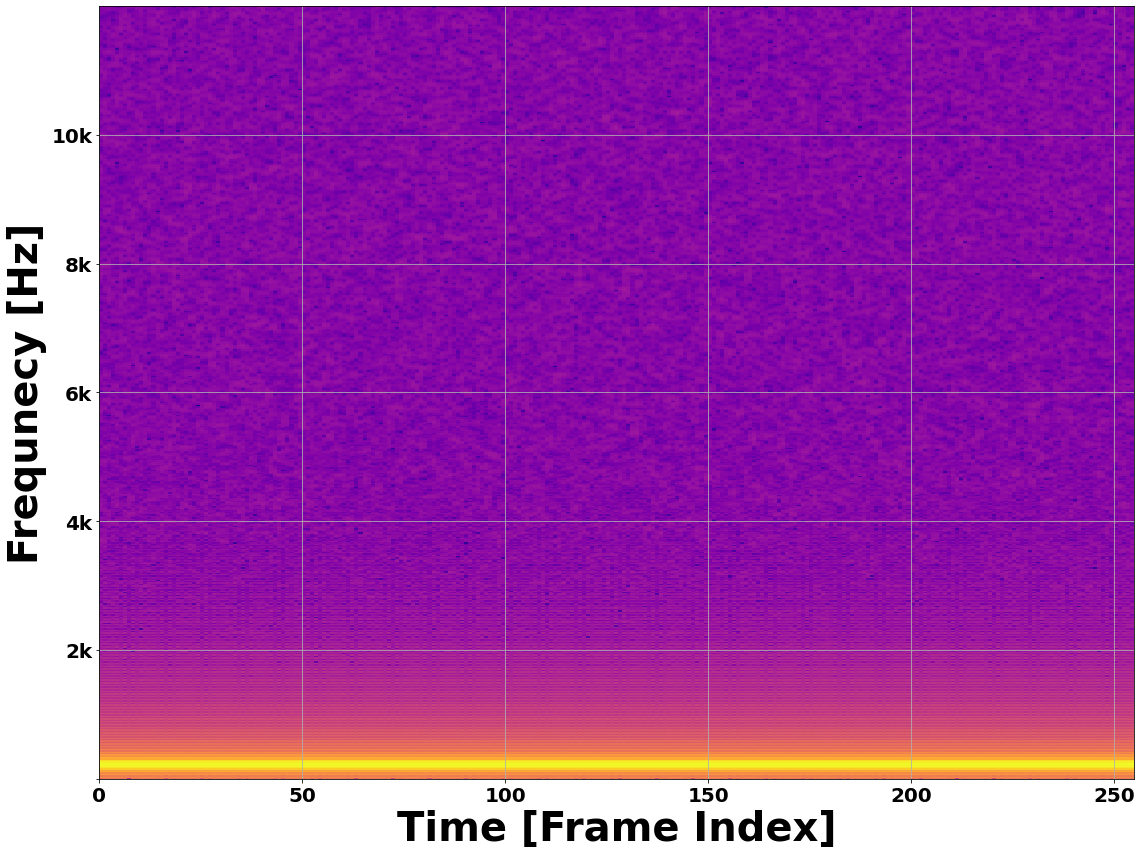

In [8]:
print(wavFiles[8])
ShowSpectrogram(wavFiles[8])

AltoSax-A4.wav
Xshape: (723, 2048)
Zshape: (723, 2048)
(558, 256)
CELLO-F4.wav
Xshape: (362, 2048)
Zshape: (362, 2048)
(558, 256)
Clarinet-Gs5.wav
Xshape: (267, 2048)
Zshape: (267, 2048)
(558, 256)
FLUTE-Cs6.wav
Xshape: (164, 2048)
Zshape: (164, 2048)
(558, 256)


<ipython-input-6-fb7d0b7bd689>:23: RuntimeWarning: divide by zero encountered in log
  Sxx = np.log(Sxx)


FRENCHHORN-Cs4.wav
Xshape: (285, 2048)
Zshape: (285, 2048)
(558, 256)
GUITAR-B2.wav
Xshape: (1082, 2048)
Zshape: (1082, 2048)
(558, 256)
Oboe.Bb4.R.wav
Xshape: (305, 2048)
Zshape: (305, 2048)
(558, 256)
SawtoothWave-220.wav
Xshape: (1036, 2048)
Zshape: (1036, 2048)
(558, 256)
SineWave-220.wav
Xshape: (1036, 2048)
Zshape: (1036, 2048)
(558, 256)
SquareWave-220.wav
Xshape: (1036, 2048)
Zshape: (1036, 2048)
(558, 256)
TriangleWave-220.wav
Xshape: (1036, 2048)
Zshape: (1036, 2048)
(558, 256)
Trumpet-B3.wav
Xshape: (743, 2048)
Zshape: (743, 2048)
(558, 256)
Tuba-A2.wav
Xshape: (269, 2048)
Zshape: (269, 2048)
(558, 256)
Viola-G4.wav
Xshape: (685, 2048)
Zshape: (685, 2048)
(558, 256)
Violin-G4.wav
Xshape: (468, 2048)
Zshape: (468, 2048)
(558, 256)
WhiteNoise-190.wav
Xshape: (1036, 2048)
Zshape: (1036, 2048)
(558, 256)


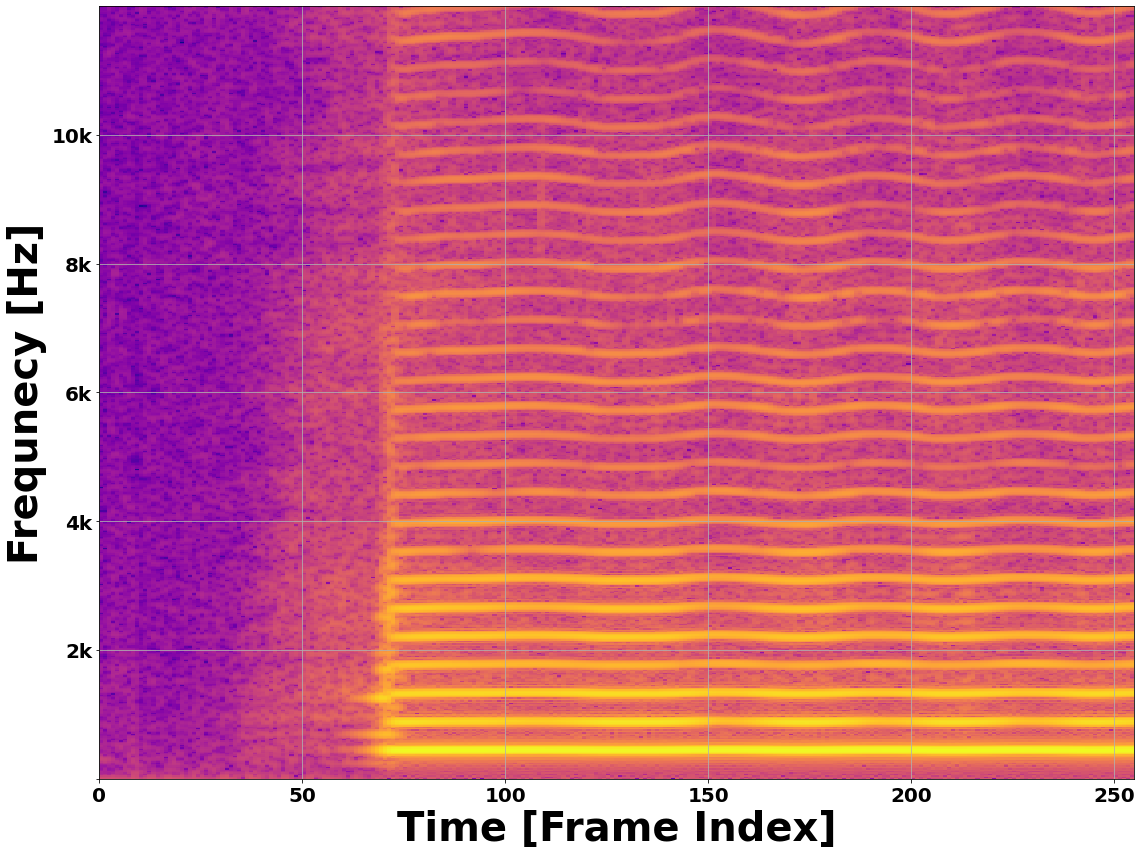

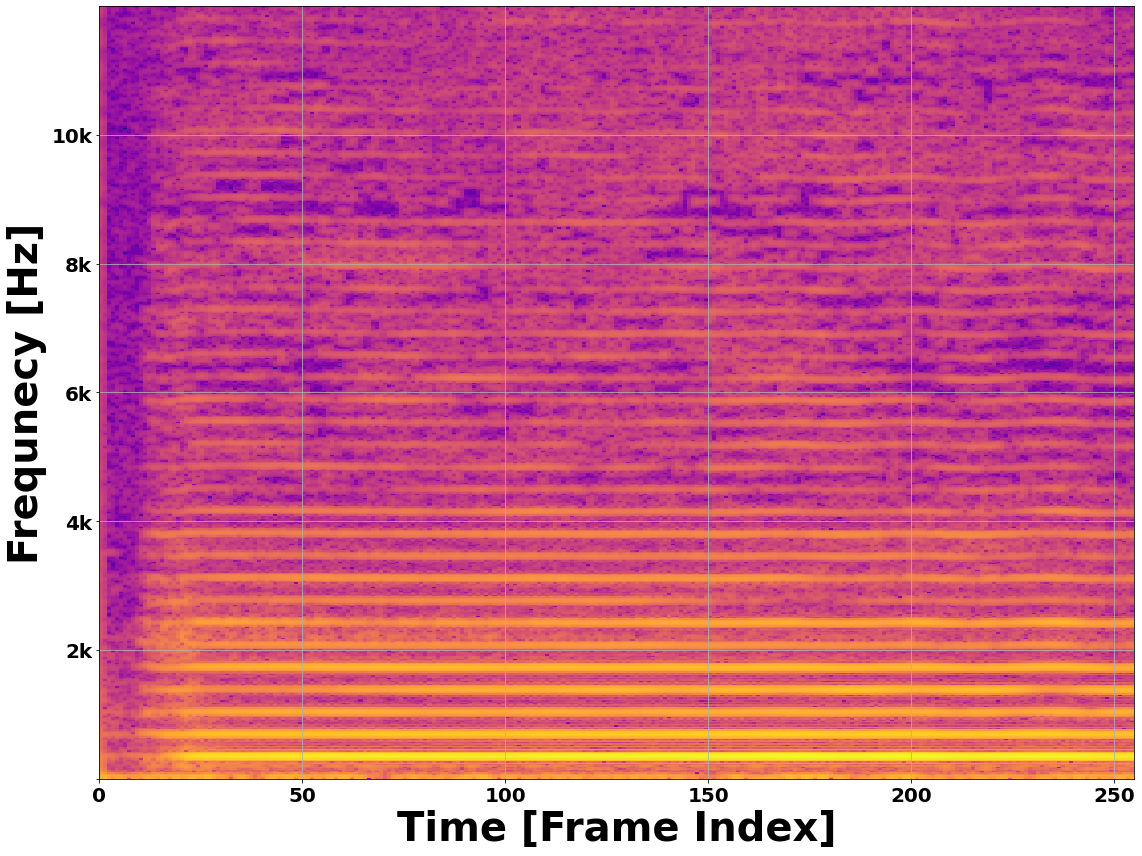

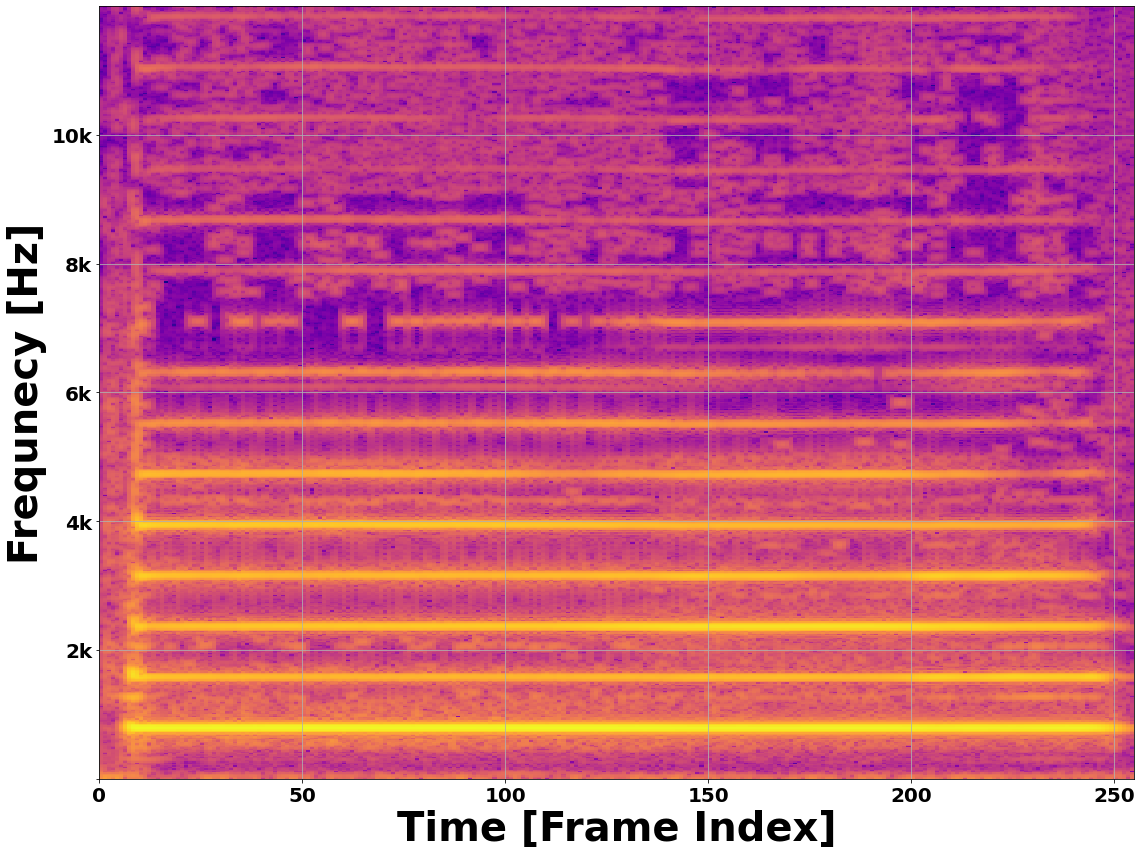

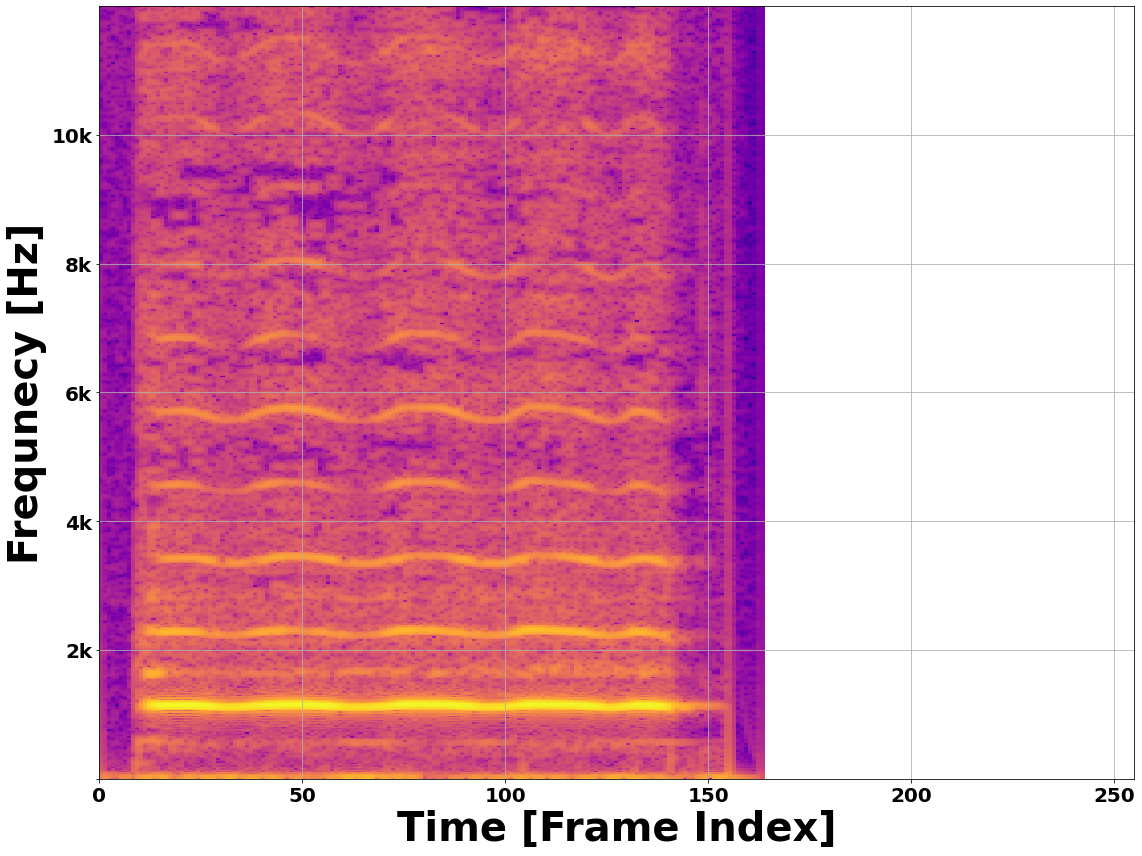

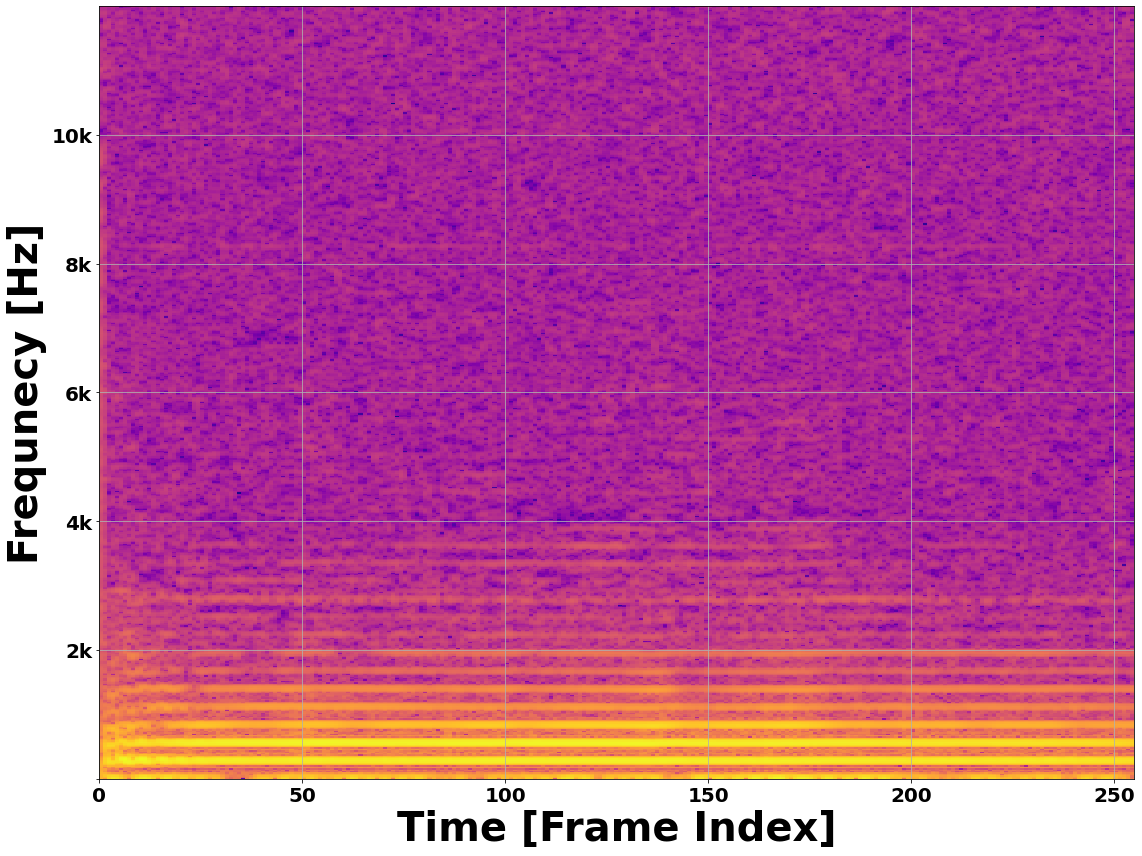

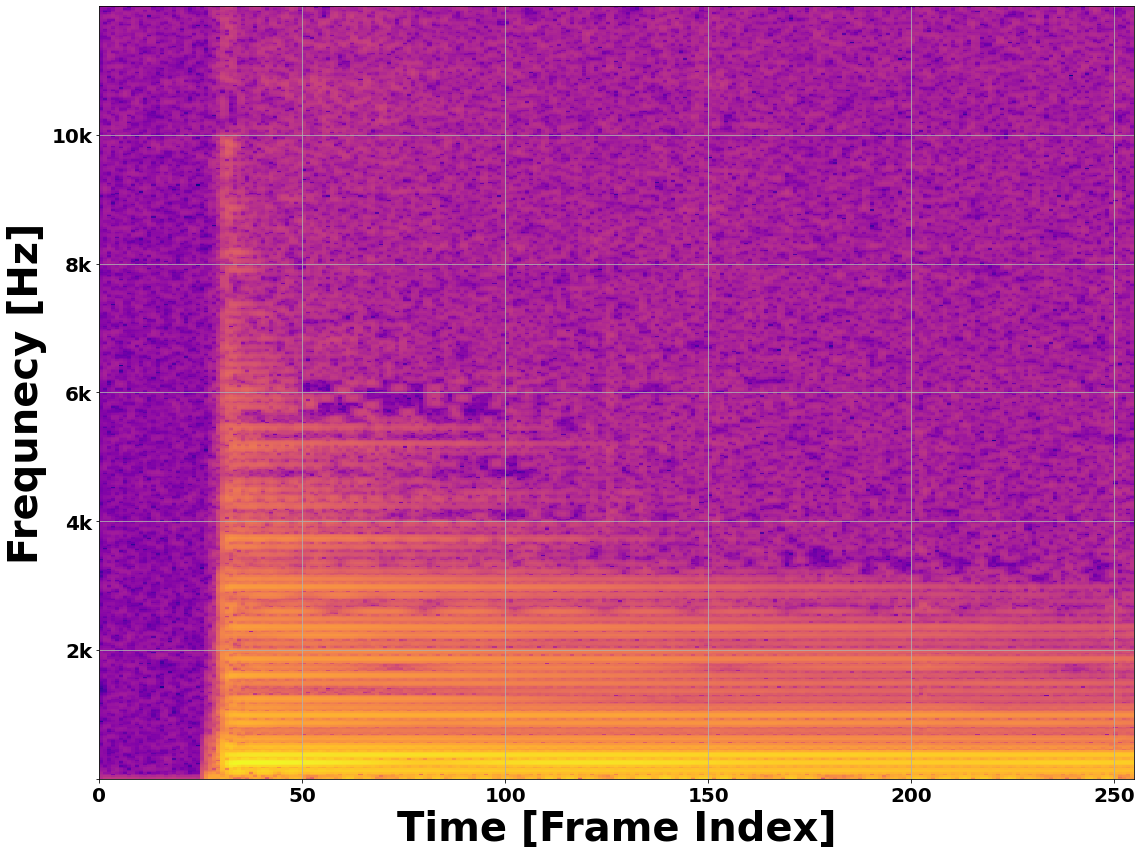

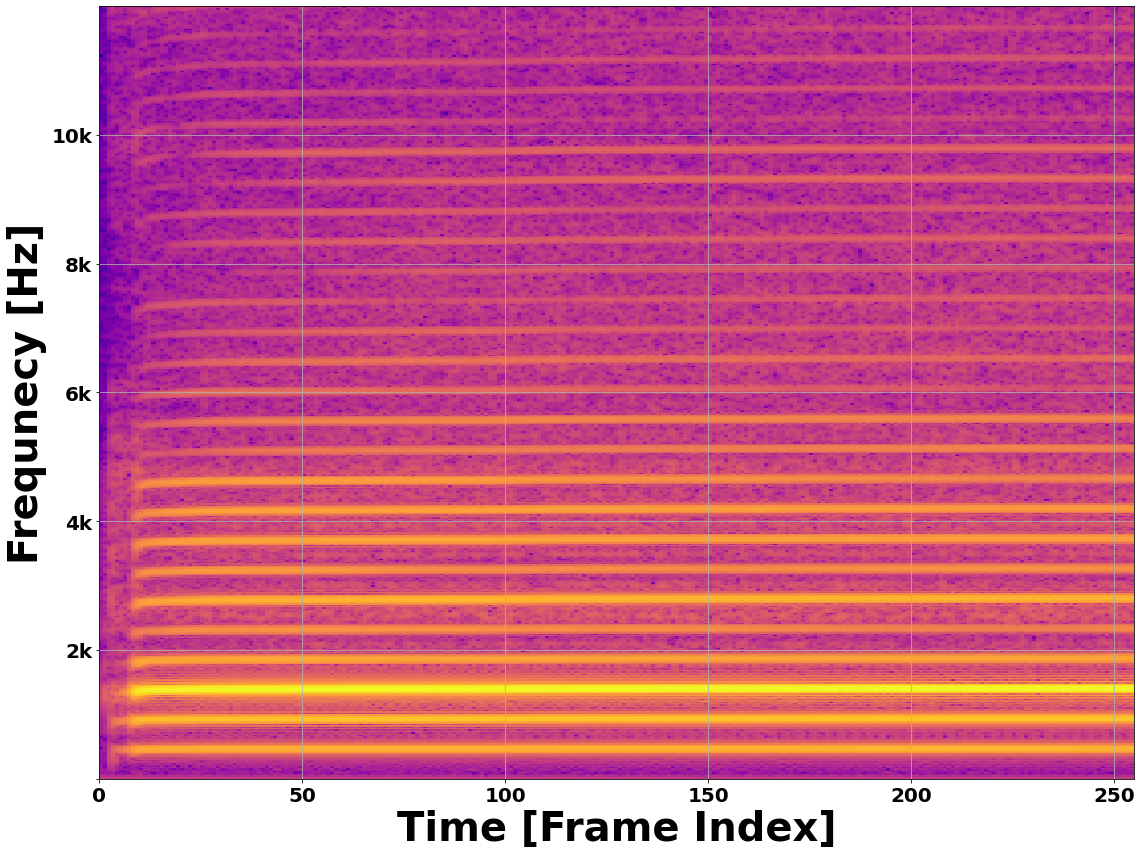

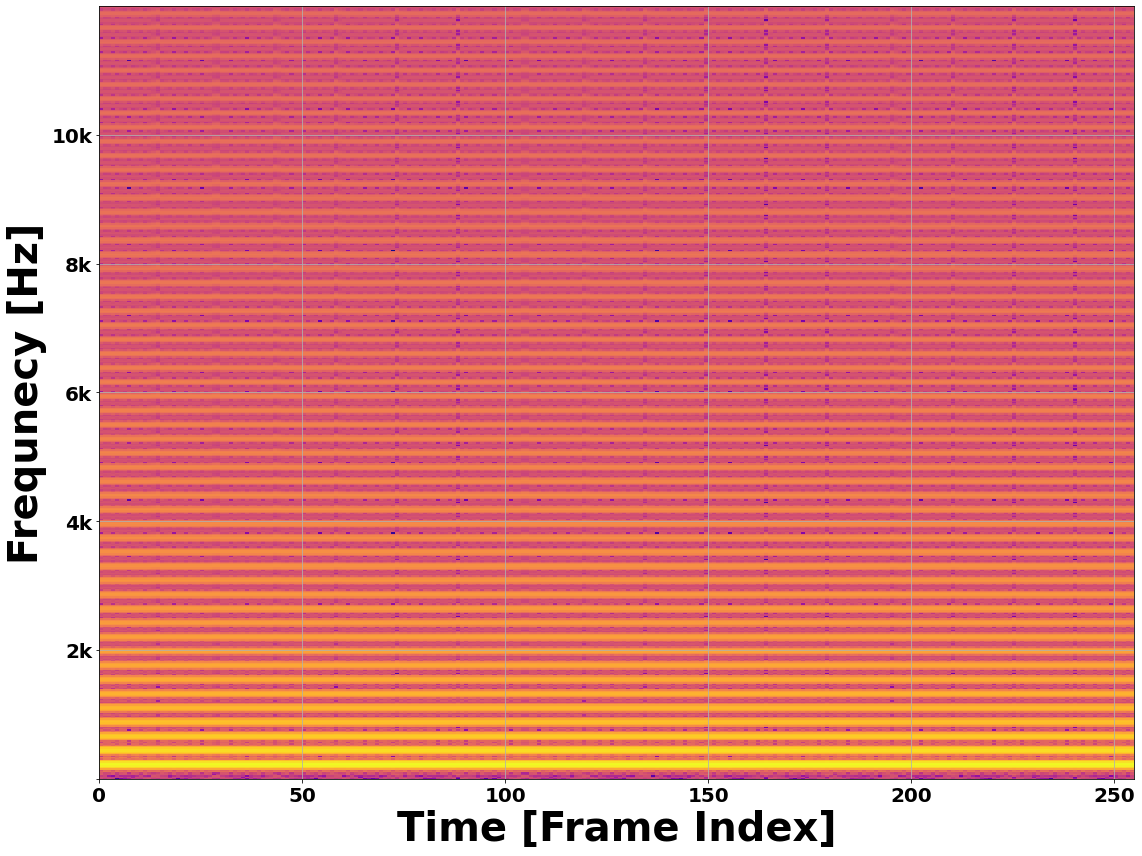

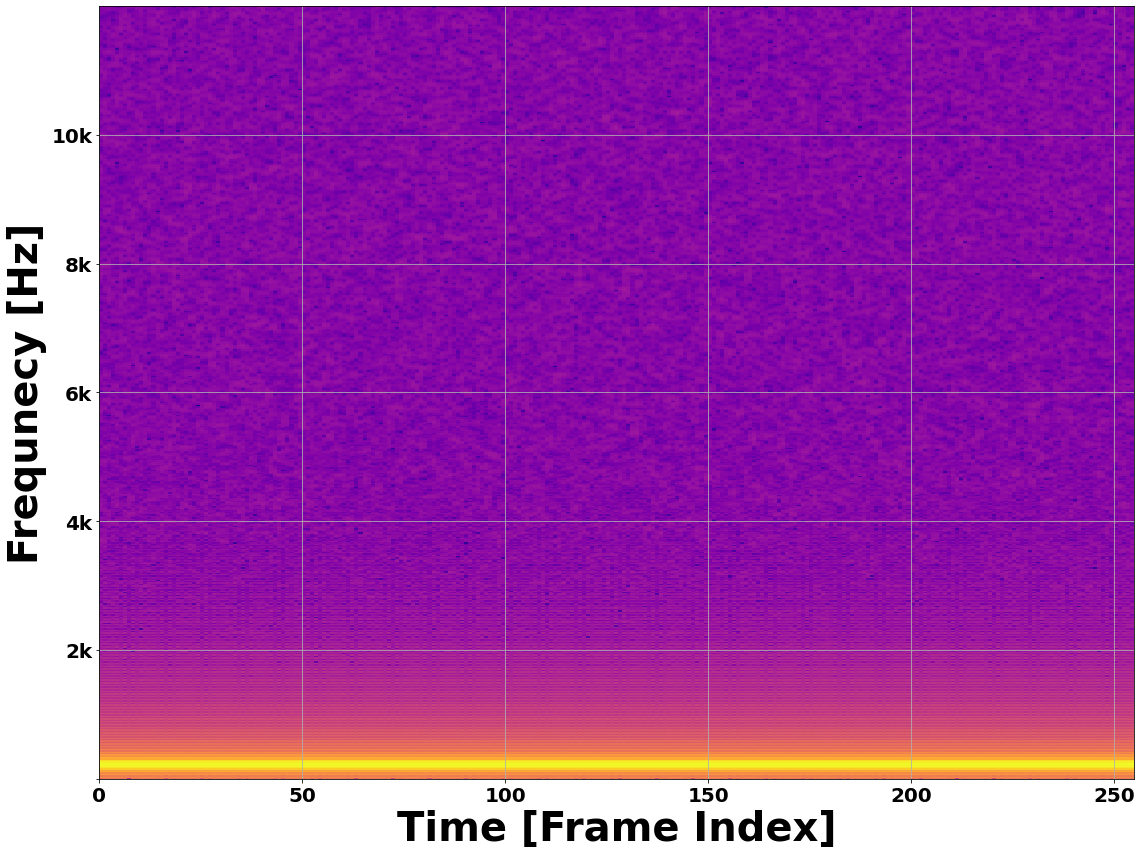

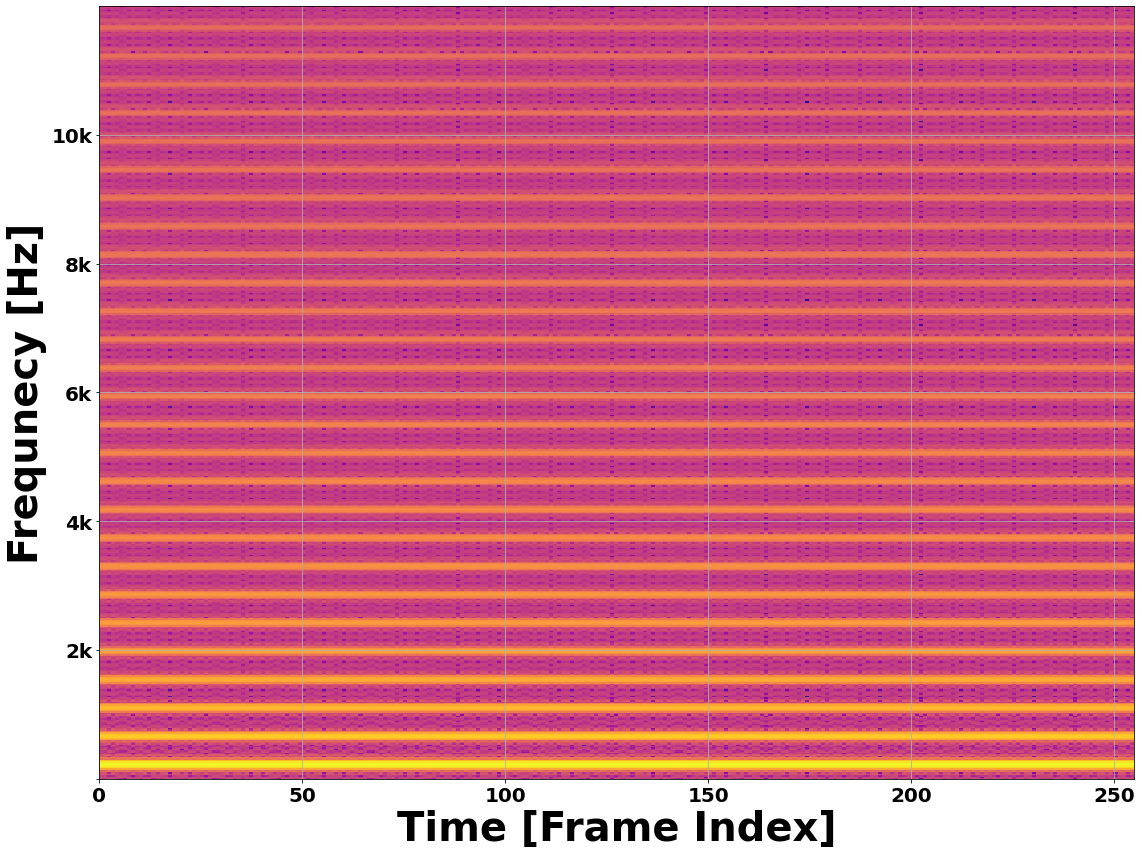

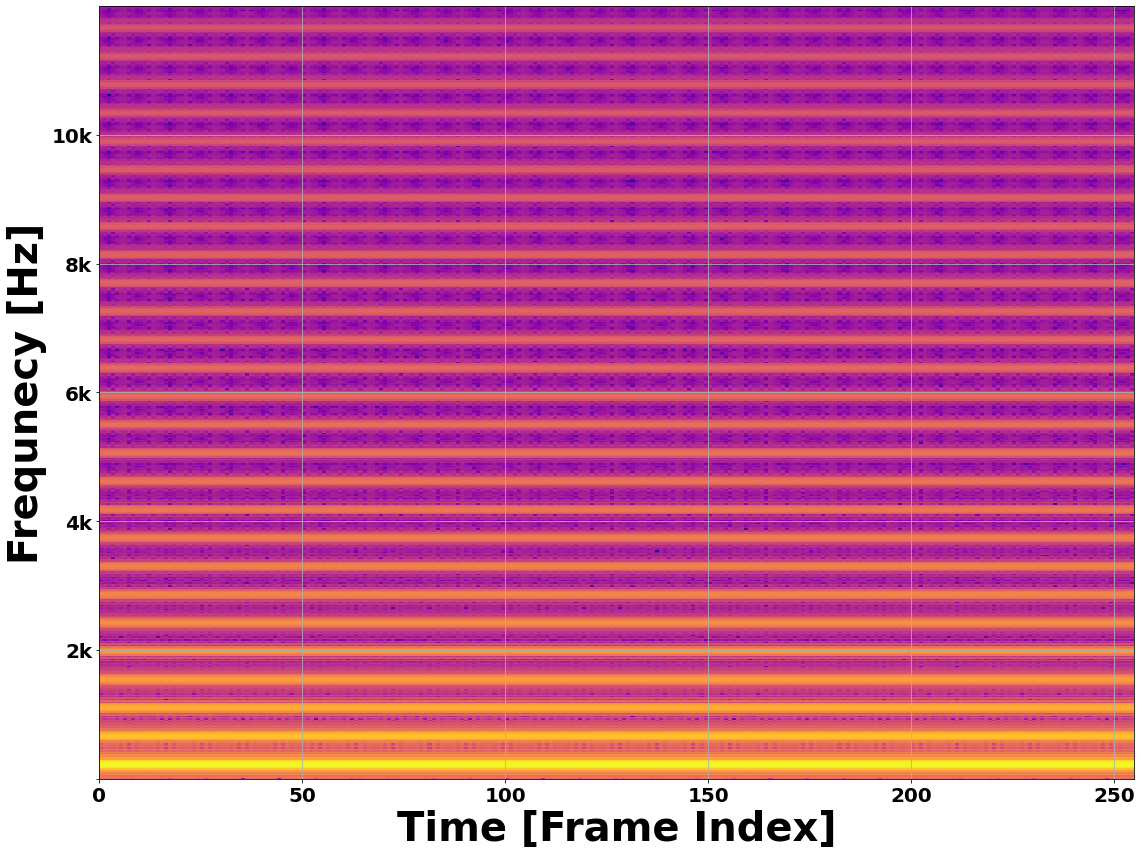

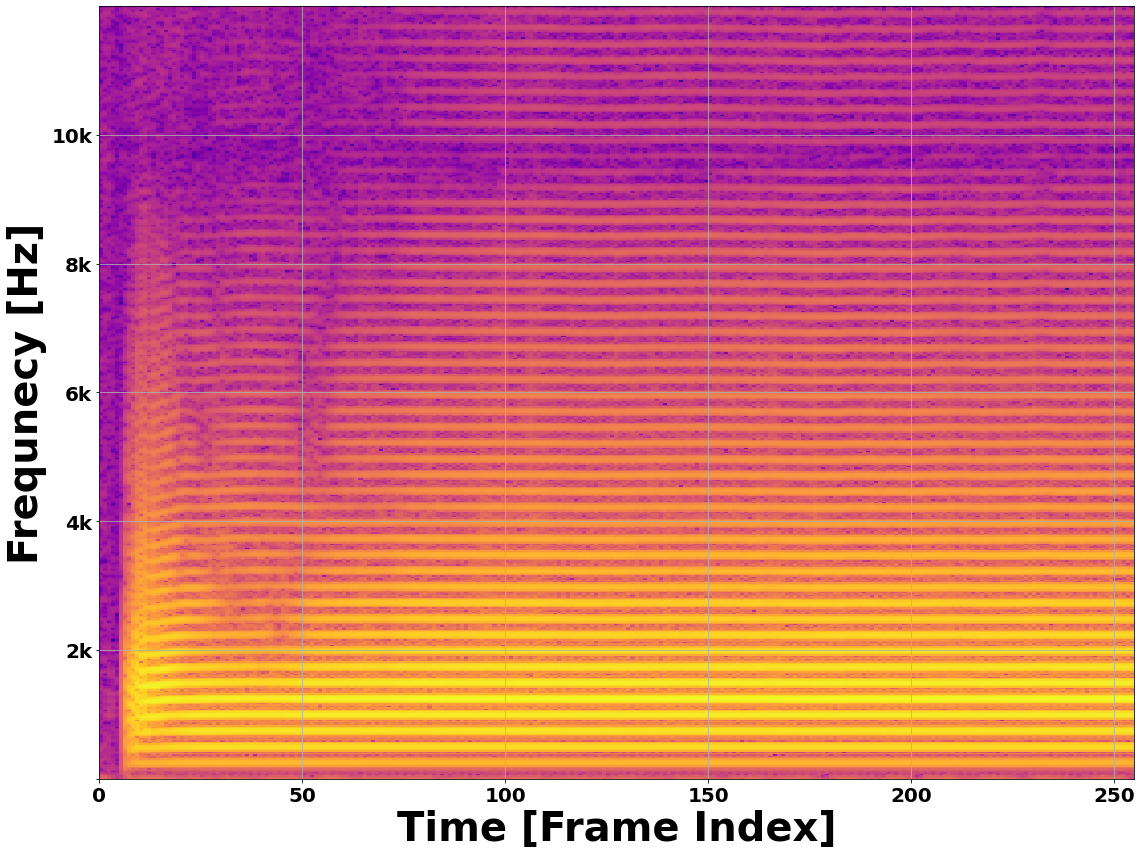

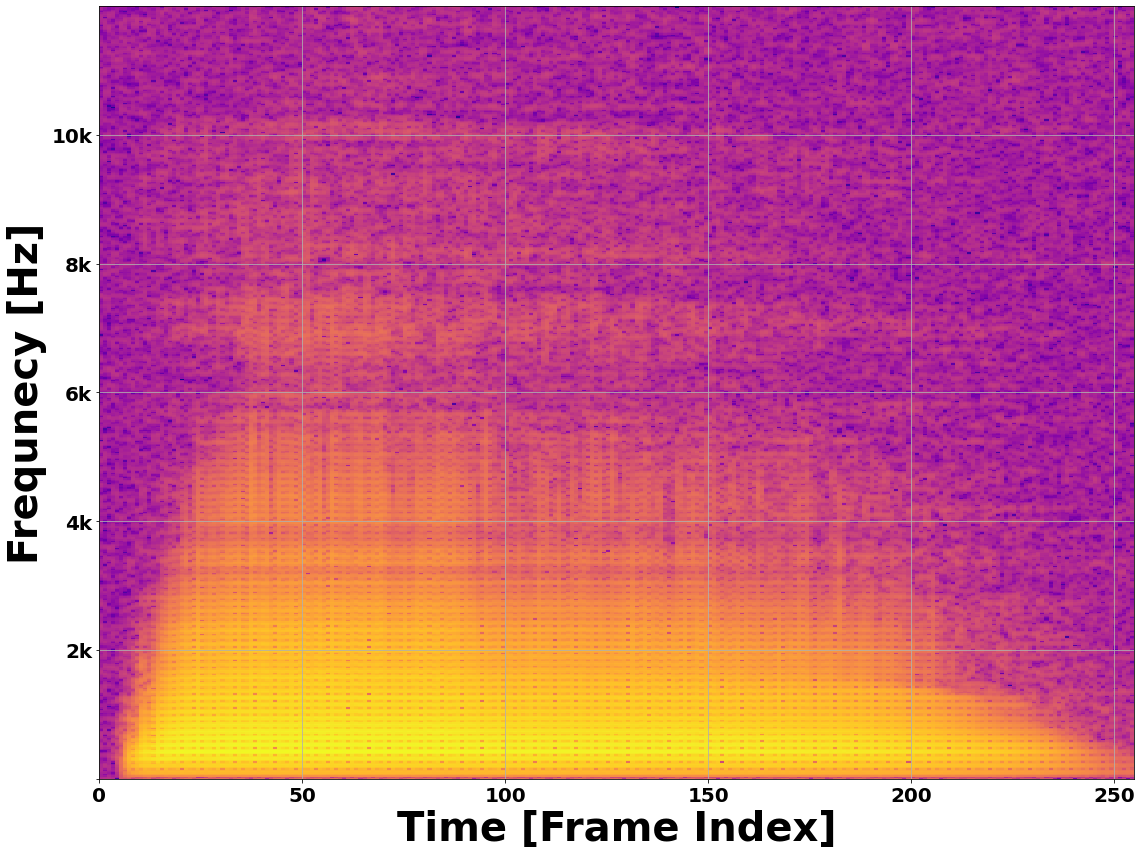

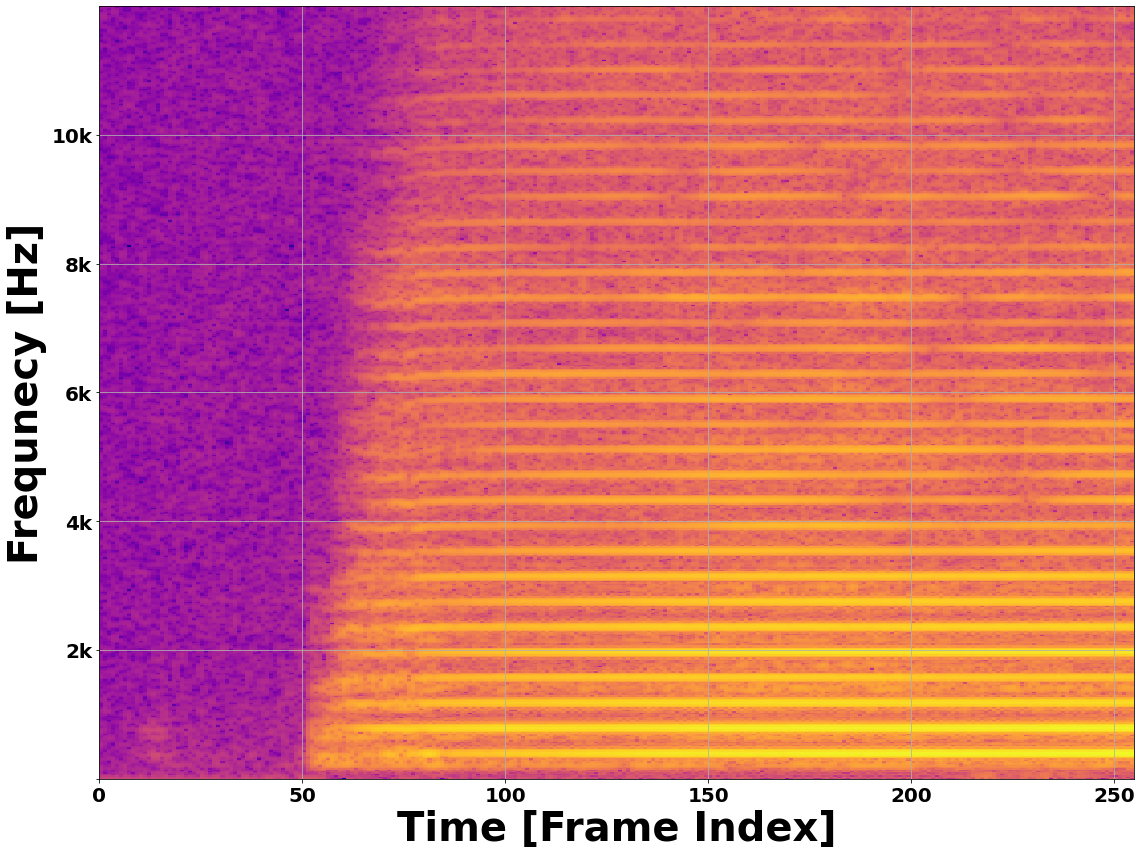

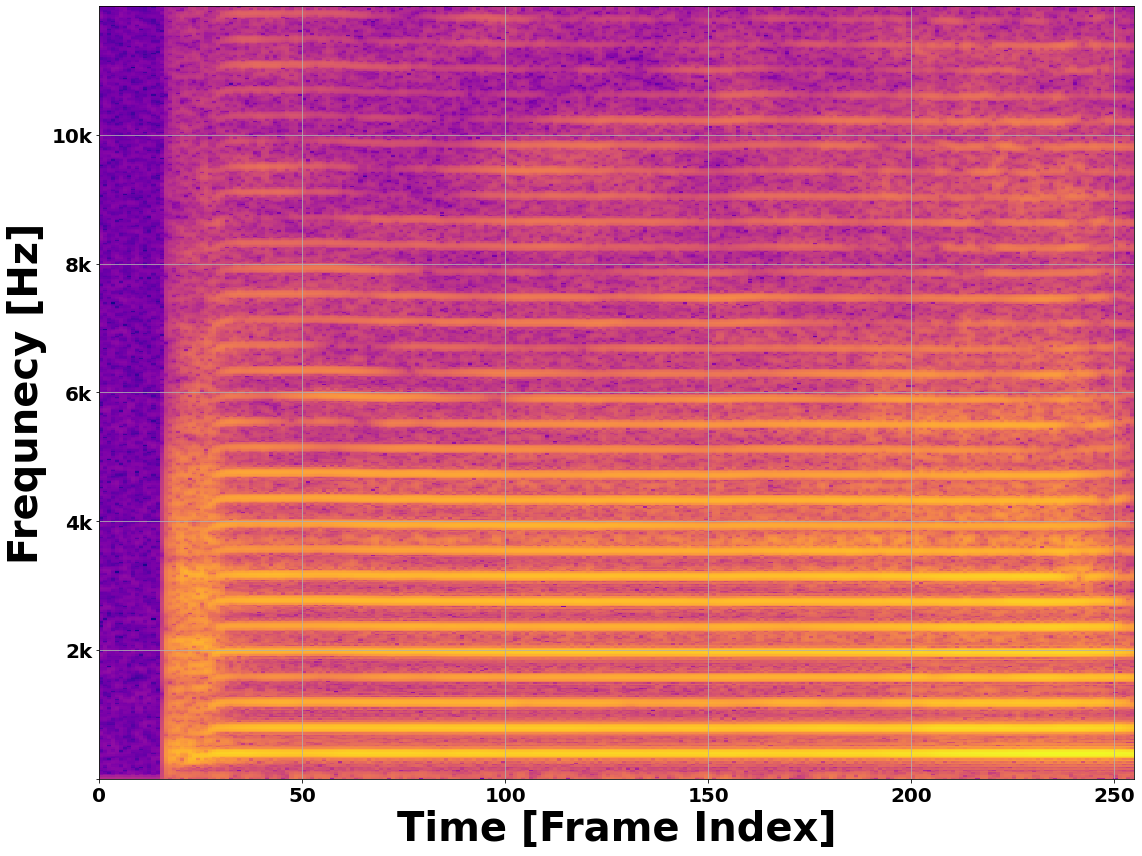

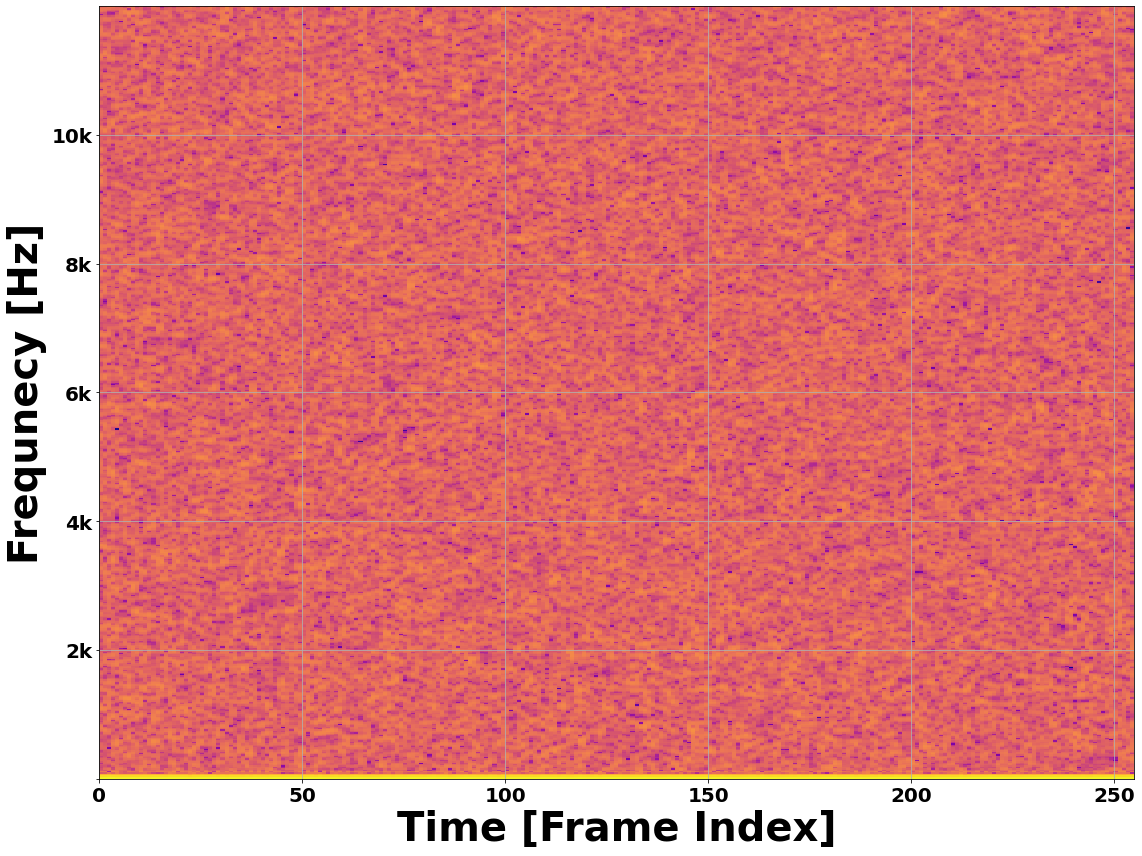

In [9]:
for i in range(len(wavFiles)):
    print(wavFiles[i])
    ShowSpectrogram(wavFiles[i])